### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#### Install Pytorch Geometric Temporal

In [2]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torch-geometric-temporal

2.0.1+cu118
11.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86722 sha256=1e8efd46c96f38042b60b9b552674305d1fea7cdc3dcf22fb61bc8d79574f7dd
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=494366 sha256=9491b792e9312cf9197d2c848289975ad00617487dddfcd5

### `ASLTemporalDataSet`

Integrating temporal aspects into the graph creation process will allow the model to harness temporal dependencies among different frames in a video sequence. For implementing this in a Temporal Graph Neural Network (TGNN) using PyTorch Geometric Temporal, the data loader yields sequences of graph snapshots.

The `ASLDatasetLoader` which accumulates a sequence of graphs (frames) for each sign and returns temporal sequences along with their labels. Further, it uses a custom dataset class, `ASLTemporalDataset`, to handle and batch these sequences properly for training a temporal graph neural network.

The `get_temporal_dataset` returns sequences of graph snapshots as training samples instead of individual graphs. Each item in the dataset is a sequence of `sequence_length` graphs and their associated label, which enables training on temporal sequences of graphs.

### `ASLDatasetLoader` Class

The `ASLDatasetLoader` class is designed for loading and processing the ASL dataset. Given a directory, it reads sign language data from JSON files and constructs graph representations suitable for graph-based neural networks. Crucially, the class converts JSON data into PyTorch Geometric (PyG) `Data` objects comprising `x` (node features), `edge_index` (graph connectivity), and `y' (labels) attributes.

**Methods**:

- `_create_sign_to_label_map`: Generates a mapping from sign names to unique labels.

- `_read_file_data`: Reads data from a given JSON file.

- `_augment_data`: Implements data augmentation by applying random rotation, translation, and scaling to landmarks, which can enhance the model's robustness.

- `_create_graph_from_frame`: Constructs a PyG `Data` object from frame data, concentrating on hand and face landmarks. Edges are created between consecutive landmarks and between left and right hand landmarks. Additional features, like hand-to-face distances, are also computed.

- `get_dataset`: Assembles the dataset, optionally incorporating data augmentation. The function outputs a list of PyG `Data` objects ready for graph neural network processing.

In [6]:
import torch
import os
import json
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader

class ASLTemporalDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences  # List of lists of graph snapshots for each sign sequence
        self.labels = labels  # Corresponding labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, torch.tensor(label, dtype=torch.long)


class ASLDatasetLoader:
    def __init__(self, directory_path, max_classes=None):
        self.directory_path = directory_path
        self.max_classes = max_classes
        self.sign_to_label = self._create_sign_to_label_map()

        # Debug: Print the sign_to_label mapping
        print("sign_to_label mapping:", self.sign_to_label)

    def _create_sign_to_label_map(self):
        # Get all sign names from the filenames in directory_path
        all_signs = [os.path.splitext(filename)[0] for filename in os.listdir(self.directory_path)]

        # If max_classes is specified, select a subset of the sign names
        if self.max_classes is not None:
            all_signs = all_signs[:self.max_classes]

        # Create a mapping from sign names to labels
        return {sign: i for i, sign in enumerate(all_signs)}

    def _read_file_data(self, file_path):
        with open(file_path, 'r') as f:
            return json.load(f)

    def _augment_data(self, frame_data, rotation_range=10, translation_range=0.05, scaling_range=0.1):
        """
        Augment the frame data with random rotation, translation, and scaling.

        :param frame_data: Dictionary containing frame landmarks and deltas.
        :param rotation_range: Maximum rotation angle in degrees.
        :param translation_range: Maximum translation as a fraction of landmark range.
        :param scaling_range: Maximum scaling factor.
        :return: Augmented frame data.
        """
        landmarks = np.array(frame_data["landmarks"])
        centroid = np.mean(landmarks, axis=0)

        # Random rotation
        theta = np.radians(np.random.uniform(-rotation_range, rotation_range))
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        landmarks = np.dot(landmarks - centroid, rotation_matrix) + centroid

        # Random translation
        max_translation = translation_range * (landmarks.max(axis=0) - landmarks.min(axis=0))
        translations = np.random.uniform(-max_translation, max_translation)
        landmarks += translations

        # Random scaling
        scale = np.random.uniform(1 - scaling_range, 1 + scaling_range)
        landmarks = centroid + scale * (landmarks - centroid)

        frame_data["landmarks"] = landmarks.tolist()
        return frame_data

    def _calculate_dominant_hand(self, sign_data):
        """
        Determine the dominant hand in a sign language data sample.

        This function analyzes the motion of both hands throughout the frames in
        a given sign language data sample. The dominant hand is determined based
        on the average magnitude and frequency of motion. The hand with the
        higher average magnitude or higher motion event frequency is considered
        dominant.

        Returns
        -------
        str
            A string indicating the dominant hand. Possible return values are
            "left", "right", or "ambiguous" if no clear dominant hand can be
            determined.

        Notes
        -----
        The function assumes that the order of landmarks and deltas is consistent
        across frames and that hands' landmarks are distinguishable in the
        landmark data (e.g., by their order or a separate landmark type identifier).

        The decision criterion for dominant hand detection is heuristic and may
        require adjustment based on empirical results and specific use case needs.
        """
        left_hand_motion = 0
        right_hand_motion = 0
        left_hand_motion_events = 0
        right_hand_motion_events = 0

        for frame_data in sign_data["frames"]:
            landmarks = np.array(frame_data["landmarks"])
            deltas = np.array(frame_data["deltas"])
            landmark_types = frame_data["landmark_types"]

            for delta, ltype in zip(deltas, landmark_types):
                motion_magnitude = np.linalg.norm(delta)

                if ltype == "L":
                    left_hand_motion += motion_magnitude
                    if motion_magnitude > 0.5:  # Threshold may need adjustment
                        left_hand_motion_events += 1

                elif ltype == "R":
                    right_hand_motion += motion_magnitude
                    if motion_magnitude > 0.5:  # Threshold may need adjustment
                        right_hand_motion_events += 1

        # Combine motion magnitude and motion events to determine the dominant hand
        # Weights (0.5 and 0.5) might need adjustment based on empirical observation
        left_hand_score = 0.5 * left_hand_motion + 0.5 * left_hand_motion_events
        right_hand_score = 0.5 * right_hand_motion + 0.5 * right_hand_motion_events

        return "left" if left_hand_score > right_hand_score else "right"


    def _create_graph_from_frame(self, sign_name, frame_data, sign_data, landmark_types):
        # Calculate dominant hand
        dominant_hand = self._calculate_dominant_hand(sign_data)

        # Extract landmark and delta information
        landmarks = np.array(frame_data["landmarks"])
        deltas = np.array(frame_data["deltas"])

        # Add dominant hand information to node features
        dominant_hand_feature = [
            1 if ((t == "L" and dominant_hand == "left") or (t == "R" and dominant_hand == "right")) else 0
            for t in landmark_types
        ]
        dominant_hand_feature_2d = np.array(dominant_hand_feature)[:, np.newaxis]

        # Compute additional features like hand-to-face and hand-to-body distances
        # ... (If you have additional feature creation logic, add here)
        hand_to_face_contact = [0] * len(landmark_types) # replace this line with actual feature creation if used
        hand_to_face_contact_2d = np.array(hand_to_face_contact)[:, np.newaxis]

        # Create weights based on landmark importance
        weights = [2 if t == "L" or t == "R" else 1 for t in landmark_types]
        weights_2d = np.array(weights)[:, np.newaxis]

        # Concatenate landmarks, deltas, importance weights, hand-to-face contact features, and dominant hand feature
        x = torch.tensor(np.hstack((landmarks, deltas, weights_2d, hand_to_face_contact_2d, dominant_hand_feature_2d)), dtype=torch.float)
        y = torch.tensor([self.sign_to_label[sign_name]], dtype=torch.long)

        # Create edges based on the number of available landmarks (or nodes)
        # You might have specific logic to determine edges based on landmark types or spatial proximity
        edges = [[i, i + 1] for i in range(len(landmarks) - 1)]

        # Add edges between the left and right hand landmarks
        for i, t1 in enumerate(landmark_types):
            for j, t2 in enumerate(landmark_types):
                if t1 in ["L", "R"] and t2 in ["L", "R"] and i != j:
                    edges.append([i, j])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

        return Data(x=x, edge_index=edge_index, y=y)

    def get_dataset(self, augment=False):
      dataset = []

      for filename in os.listdir(self.directory_path):
          sign_name = os.path.splitext(filename)[0]
          file_path = os.path.join(self.directory_path, filename)
          sign_data = self._read_file_data(file_path)

          for frame_data in sign_data["frames"]:
              landmark_types = sign_data.get("landmark_types", ["F", "L", "P", "R"])  # defaulting to all types

              if augment:
                  frame_data = self._augment_data(frame_data)
              graph_data = self._create_graph_from_frame(sign_name, frame_data, sign_data, landmark_types)

              dataset.append(graph_data)

      return dataset

    def number_of_classes(self):
        return len(self.sign_to_label)

    def get_temporal_dataset(self, sequence_length=16, augment=True):
        data_list = []

        # Set a stride length for sub-sampling sequences
        stride = 1

        # Define the landmark types
        landmark_types = ["LANDMARKS", "DELTA_LANDMARKS", "HAND_CONTACT", "DOMINANT_HAND"]

        # Debug: Print the directory path
        # print(f"Directory Path: {self.directory_path}")

        # Debug: Print the filenames in the directory
        # print("Filenames:", os.listdir(self.directory_path))

        # Iterate through each sign and its corresponding data
        for filename in os.listdir(self.directory_path):
            sign_name = os.path.splitext(filename)[0]

            # Debug: Print the sign name
            # print(f"\nProcessing: {sign_name}")

            if sign_name not in self.sign_to_label:
                # print(f"Skipping {sign_name}: not in sign_to_label mapping")
                continue

            file_path = os.path.join(self.directory_path, filename)
            sign_data = self._read_file_data(file_path)

            # Debug: Print a sample of sign data and its length
            # print(f"Sample data for {sign_name}: {str(sign_data)[:100]}")
            # print(f"Length of sign data: {len(sign_data)}")

            # Ensure there's enough data to create at least one sequence
            if len(sign_data['frames']) < sequence_length:  # Corrected line
                print(f"Skipping {sign_name}: Not enough data for a single sequence.")
                continue

            for i in range(0, len(sign_data['frames']) - sequence_length + 1, stride):  # Corrected line
                sequence_buffer = []
                # print(f"Processing sequence starting at index {i}")  # Debug: Check loop entry

                for j in range(i, i + sequence_length):
                    frame_data = sign_data['frames'][j]  # Corrected line

                    if augment:
                        frame_data = self._augment_data(frame_data)

                    graph_data = self._create_graph_from_frame(sign_name, frame_data, sign_data, landmark_types)
                    sequence_buffer.append(graph_data)

                # print(f"Sequence buffer length: {len(sequence_buffer)}")  # Debug: Check buffer population
                data_list.append((sequence_buffer, self.sign_to_label[sign_name]))

        # Debug: Print the total number of sequences
        print(f"\nTotal sequences created: {len(data_list)}")

        return data_list

### `TemporalASLGraphClassifier` Class

In a Temporal Graph Neural Network, the input is a sequence of graph snapshots, and the model learns to capture temporal dependencies among these snapshots.

This loop assumes that each `graph_sequence` in the data loader is a sequence of `Data` objects. The model processes each graph in the sequence individually, and the outputs are aggregated (e.g., by considering the last output) for loss calculation and backpropagation.

Note: The model architecture, sequence handling, and output aggregation may require further adjustments based on empirical observation and specific use case needs.

The Diffusion Convolutional Recurrent Neural Network (DCRNN) model is specifically designed for handling spatio-temporal data, like traffic flow between sensors across a city. It utilizes both spatial and temporal dependencies in the data during training.

In the context of the ASL dataset, considering DCRNN might be a viable option if you are exploring temporal dependencies between different graph snapshots in the sequence. DCRNN could potentially provide more nuanced temporal learning, especially if spatial (graph structure) and temporal (sequence) aspects are intertwined.

Some points to consider:

* **Complexity**: DCRNN introduces additional complexity due to its recurrent diffusion convolution mechanism. Make sure to validate if this complexity is warranted by monitoring the training progress and validation performance.

* **Computational Cost**: Depending on the size of your graphs, sequences, and dataset, the DCRNN might be computationally intensive. Ensure your hardware setup can handle this, and be mindful of training times.

* **Hyperparameter Tuning**: DCRNN, with its additional complexity, might require careful hyperparameter tuning (like learning rate, dropout rate, etc.) to ensure stable and meaningful training.

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

class TemporalASLGraphClassifier(torch.nn.Module):
    def __init__(self, node_features, hidden_size, num_classes):
        super(TemporalASLGraphClassifier, self).__init__()
        self.dcrnn = DCRNN(node_features, hidden_size, 1)  # DCRNN layer for spatial-temporal learning
        self.rnn = torch.nn.LSTM(hidden_size, hidden_size, batch_first=True)  # LSTM for temporal sequences
        self.linear = torch.nn.Linear(hidden_size, num_classes)  # Final classification layer
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout for regularization

    def forward(self, graph_sequence):
        # Assuming graph_sequence is a list of Data objects representing a sequence of graphs
        h_sequence = []
        for graph in graph_sequence:
            print("Type of graph:", type(graph))
            print("Content of graph:", graph)
            h = self.dcrnn(graph.x, graph.edge_index)
            h = F.relu(h)
            # Global Attention (sum-pooling)
            h = torch.sum(h, dim=0)
            h_sequence.append(h.unsqueeze(0))

        h_sequence = torch.cat(h_sequence, dim=0).unsqueeze(0)  # Combining all graph representations in the sequence
        # LSTM to handle temporal dependencies
        h_sequence, (hn, cn) = self.rnn(h_sequence)

        # Final classification
        out = self.linear(h_sequence.squeeze(0)[-1])  # Using the last LSTM output for classification
        return out

* The stratified_data_split function now extracts labels from the first graph in each sequence.
* The training loop (train_temporal) and validation (validate) function have been modified to handle sequences of graphs.

In [2]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

EPOCHS = 2
LEARNING_RATE = 0.001

def stratified_data_split(data_list, test_size=0.2):
    # Extract labels from data list
    labels = [label for sequence, label in data_list]
    train_data, test_data = train_test_split(data_list, test_size=test_size, stratify=labels, random_state=42)
    return train_data, test_data

def validate(loader, model, device):
    model.eval()
    correct = 0
    for batch_sequences in loader:
        batch_labels = [sequence[0].y.item() for sequence in batch_sequences]  # Using first graph in sequence for label
        batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
        # batch_sequences_device = [[graph.to(device) for graph in sequence] for sequence in batch_sequences]
        batch_sequences_device = [sequence.to(device) for sequence in batch_sequences]

        with torch.no_grad():
            out = [model(sequence) for sequence in batch_sequences_device]
            out = torch.stack(out)
        pred = out.argmax(dim=1)
        correct += int((pred == batch_labels).sum())
    return correct / len(loader.dataset)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    return sequences, torch.tensor(labels, dtype=torch.long)

def train_temporal(loader, EPOCHS=2, LEARNING_RATE=0.001):
    data_list = loader.get_temporal_dataset(sequence_length=16, augment=True)
    print(f"Total number of sequences: {len(data_list)}")

    if len(data_list) == 0:
        raise ValueError("No valid data sequences were created. Cannot proceed with training.")

    train_data, test_data = stratified_data_split(data_list, test_size=0.2)

    num_features = train_data[0][0][0].x.size(1)
    num_classes = loader.number_of_classes()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TemporalASLGraphClassifier(node_features=num_features, hidden_size=64, num_classes=num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=5, verbose=True)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

    train_labels = [label for sequence, label in train_data]
    test_labels = [label for sequence, label in test_data]

    print("Training label distribution:", Counter(train_labels))
    print("Test label distribution:", Counter(test_labels))

    max_epochs_without_improvement = 20
    epochs_without_improvement = 0
    best_val_accuracy = 0

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_sequences, batch_labels in train_loader:
            batch_labels = batch_labels.to(device)
            optimizer.zero_grad()

            batch_out = []
            for sequence in batch_sequences:
                sequence_out = []
                for graph in sequence:
                    print("Type of graph:", type(graph))
                    print("Content of graph:", graph)

                    # Check that the second element of the tuple is a tensor
                    if isinstance(graph[1], torch.Tensor):
                        graph_tensor = graph[1].to(device)  # Move the tensor to the device
                    else:
                        raise ValueError("Expected a tensor, but got: {}".format(type(graph[1])))

                    # If 'edge_index' is another tensor in your data, ensure you extract and use it similarly.
                    # Here, I’m using a placeholder tensor for 'edge_index' as an example.
                    edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long).to(device)

                    print(">>> graph_tensor.shape, edge_index.shape <<<")
                    print(graph_tensor.shape, edge_index.shape)

                    # Instead of using 'graph.x' and 'graph.edge_index', use 'graph_tensor' and 'edge_index' directly.
                    h = model.dcrnn(graph_tensor, edge_index)
                    h = F.relu(h)
                    h = torch.sum(h, dim=0)
                    sequence_out.append(h.unsqueeze(0))

                sequence_out = torch.cat(sequence_out, dim=0).unsqueeze(0)
                sequence_out, (hn, cn) = model.rnn(sequence_out)
                out = model.linear(sequence_out.squeeze(0)[-1])
                batch_out.append(out)

            batch_out = torch.stack(batch_out)
            loss = F.cross_entropy(batch_out, batch_labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            total_loss += loss.item()

            if np.isnan(loss.item()):
                print("Warning: NaN loss detected!")

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}, Loss: {avg_loss}")

        val_accuracy = validate(test_loader, model, device)
        scheduler.step(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_epochs_without_improvement:
            print("Early stopping triggered.")
            break

    model.eval()
    correct = 0
    all_preds = []
    all_labels = []

    for batch_sequences, batch_labels in test_loader:
        batch_labels = batch_labels.to(device)

        batch_out = []
        for sequence in batch_sequences:
            sequence_out = []
            for graph in sequence:
                print("Type of graph:", type(graph))
                print("Content of graph:", graph)
                # Check that the second element of the tuple is a tensor
                if isinstance(graph[1], torch.Tensor):
                    graph_tensor = graph[1].to(device)  # Move the tensor to the device
                else:
                    raise ValueError("Expected a tensor, but got: {}".format(type(graph[1])))


                # If 'edge_index' is another tensor in your data, ensure you extract and use it similarly.
                # Here, I’m using a placeholder tensor for 'edge_index' as an example.
                edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]], dtype=torch.long).to(device)

                print(">>> graph_tensor.shape, edge_index.shape <<<")
                print(graph_tensor.shape, edge_index.shape)

                # Instead of using 'graph.x' and 'graph.edge_index', use 'graph_tensor' and 'edge_index' directly.
                h = model.dcrnn(graph_tensor, edge_index)

                h = F.relu(h)
                h = torch.sum(h, dim=0)
                sequence_out.append(h.unsqueeze(0))

            sequence_out = torch.cat(sequence_out, dim=0).unsqueeze(0)
            sequence_out, (hn, cn) = model.rnn(sequence_out)
            out = model.linear(sequence_out.squeeze(0)[-1])
            batch_out.append(out)

        batch_out = torch.stack(batch_out)
        pred = batch_out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())
        correct += pred.eq(batch_labels).sum().item()

    accuracy = correct / len(test_data)

    print(f"Accuracy: {accuracy}")
    print("Sample predictions:", all_preds[:20])
    print("Sample true labels:", all_labels[:20])

    return model, all_preds, all_labels, accuracy

ModuleNotFoundError: ignored

In [1]:
directory_path = "/content/drive/MyDrive/Colab Notebooks/DGMD E-14 Project/Datasets/ASL"
loader = ASLDatasetLoader(directory_path, max_classes=2)

train_data, val_data, test_data = data_loader.split_data(train_ratio=0.7, val_ratio=0.15)

NameError: ignored

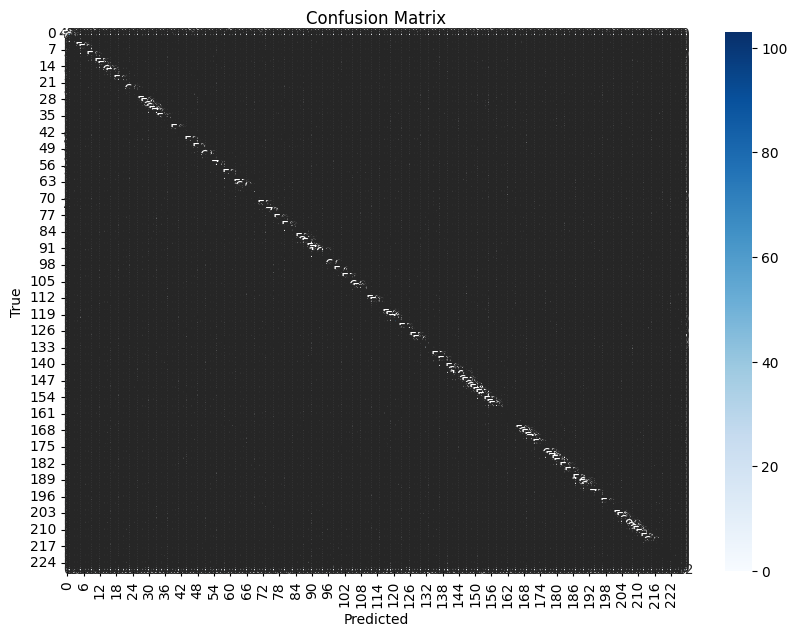

Accuracy for class 0 (apple): 76.79%
Accuracy for class 1 (airplane): 78.57%
Accuracy for class 2 (arm): 94.03%
Accuracy for class 3 (awake): 60.42%
Accuracy for class 4 (backyard): 63.24%
Accuracy for class 5 (bad): 45.45%
Accuracy for class 6 (bath): 86.21%
Accuracy for class 7 (balloon): 78.79%
Accuracy for class 8 (bee): 77.78%
Accuracy for class 9 (because): 53.85%
Accuracy for class 10 (bedroom): 78.38%
Accuracy for class 11 (before): 42.59%
Accuracy for class 12 (better): 52.73%
Accuracy for class 13 (beside): 79.71%
Accuracy for class 14 (black): 81.82%
Accuracy for class 15 (blue): 64.52%
Accuracy for class 16 (blow): 76.54%
Accuracy for class 17 (boat): 94.55%
Accuracy for class 18 (book): 54.24%
Accuracy for class 19 (boy): 56.52%
Accuracy for class 20 (brother): 96.72%
Accuracy for class 21 (brown): 78.85%
Accuracy for class 22 (bug): 48.21%
Accuracy for class 23 (bye): 70.00%
Accuracy for class 24 (callonphone): 89.61%
Accuracy for class 25 (can): 81.48%
Accuracy for class

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Convert lists to numpy arrays for compatibility with sklearn
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Ensure the class names are in the correct order for target_names
ordered_class_names = [name for name, num in sorted(loader.sign_to_label.items(), key=lambda item: item[1])]

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    class_name = ordered_class_names[i]
    print(f"Accuracy for class {i} ({class_name}): {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=1))

In [ ]:
from sklearn.metrics import classification_report

def print_top_misclassified_classes(y_true, y_pred, sign_to_label, N=3, zero_division=1):
    """
    Prints the top N classes that get misclassified the most.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels by the model
    - sign_to_label: Dictionary mapping class names to class numbers
    - N: Number of top misclassified classes to print
    - zero_division: Parameter for handling zero division in classification_report

    Returns:
    None
    """

    # Ensure the class names are in the correct order for target_names
    ordered_class_names = [name for name, num in sorted(sign_to_label.items(), key=lambda item: item[1])]

    # Generate and print classification report with class names
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=ordered_class_names, zero_division=zero_division))

    # Generate classification report as dict to find misclassified classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=zero_division)

    # Create a dictionary to store misclassification rates
    misclassification_rates = {}

    # Iterate through each class in the report
    for class_num, metrics in report.items():
        if class_num.isdigit():
            class_name = [key for key, value in sign_to_label.items() if value == int(class_num)][0]
            misclassification_rates[class_name] = 1 - metrics['recall']

    # Sort classes based on misclassification rate
    sorted_classes = sorted(misclassification_rates, key=misclassification_rates.get, reverse=True)

    # Print top N misclassified classes
    print(f"\nTop {N} misclassified classes:")
    for i in range(N):
        class_name = sorted_classes[i]
        print(f"{i+1}. {class_name} - Misclassification rate: {misclassification_rates[class_name]:.2f}")

In [ ]:
print_top_misclassified_classes(y_true, y_pred, loader.sign_to_label, N=10, zero_division=1)


Classification Report:

              precision    recall  f1-score   support

       apple       0.61      0.77      0.68        56
    airplane       0.80      0.79      0.79        70
         arm       0.94      0.94      0.94        67
       awake       0.72      0.60      0.66        48
    backyard       0.73      0.63      0.68        68
         bad       0.68      0.45      0.54        55
        bath       0.68      0.86      0.76        58
     balloon       0.87      0.79      0.83        66
         bee       0.89      0.78      0.83        54
     because       0.55      0.54      0.54        52
     bedroom       0.72      0.78      0.75        74
      before       0.62      0.43      0.51        54
      better       0.63      0.53      0.57        55
      beside       0.69      0.80      0.74        69
       black       0.82      0.82      0.82        66
        blue       0.61      0.65      0.62        62
        blow       0.83      0.77      0.79        81
  